In [52]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
from keras.models import load_model
import pickle
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.layers.experimental import preprocessing

In [53]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Loading data

In [54]:
# Load training, validation and test sets
ds_train_ = image_dataset_from_directory(
    'train',
    validation_split=0.2,
    seed=123,
    subset="training",
    image_size=(224, 224),
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_val_ = image_dataset_from_directory(
    'train',
    validation_split=0.2,
    seed=123,
    subset="validation",
    image_size=(224, 224),
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_test_ = image_dataset_from_directory(
    'test',
    image_size=(224, 224),
    interpolation = 'nearest',
    labels='inferred',
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_val = (
    ds_val_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


# Getting insights

In [55]:
class_names = np.array(ds_train_.class_names)
print('There are\033[1m {}\033[0m classes:\033[1m'.format(len(class_names)))
for class_name in class_names:
    print('\t'+class_name.upper())
print("\033[0m", end="")

There are 7 classes:
	ANGRY
	DISGUST
	FEAR
	HAPPY
	NEUTRAL
	SAD
	SURPRISE


In [56]:
y_train = np.concatenate([y for x, y in ds_train], axis=0)
y_val = np.concatenate([y for x, y in ds_val], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)

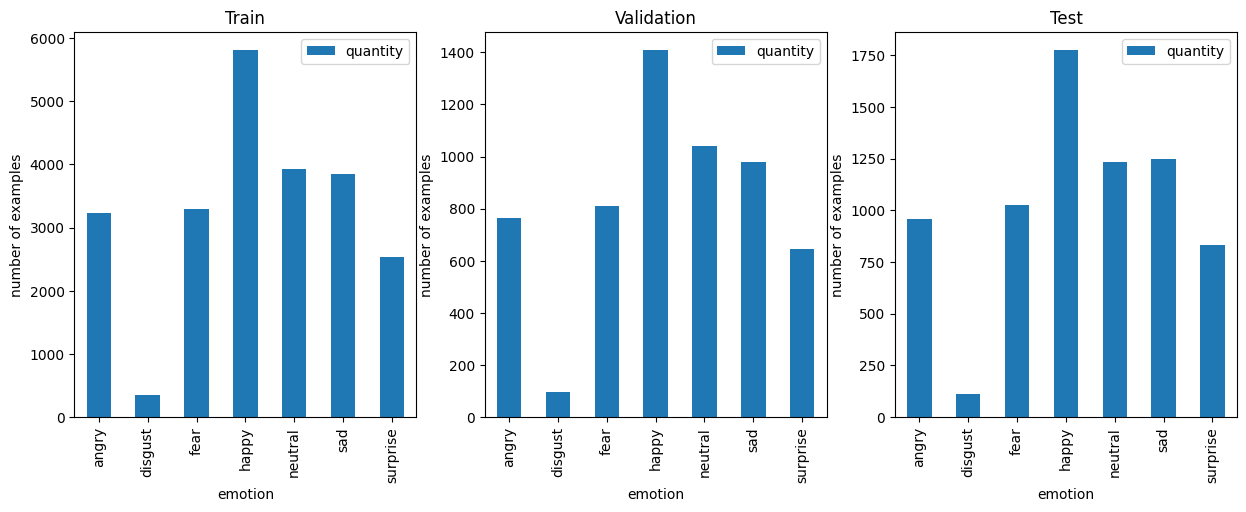

In [57]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
pd.DataFrame({'emotion':class_names[y_train], 'quantity': np.ones(y_train.shape)}).groupby('emotion').count().plot(ax=axes[0], kind='bar')
pd.DataFrame({'emotion':class_names[y_val], 'quantity': np.ones(y_val.shape)}).groupby('emotion').count().plot(ax=axes[1], kind='bar')
pd.DataFrame({'emotion':class_names[y_test], 'quantity': np.ones(y_test.shape)}).groupby('emotion').count().plot(ax=axes[2], kind='bar');

titles = ['Train','Validation','Test']
for i in range(3):
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('number of examples'); 

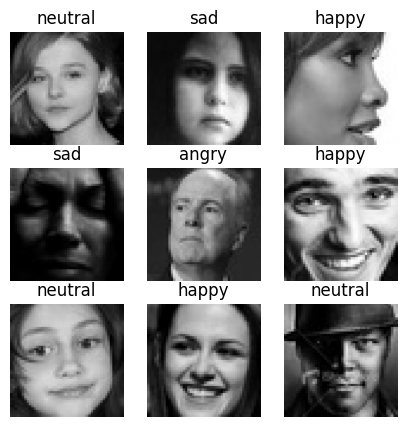

In [58]:
plt.figure(figsize=(5, 5))
for images, labels in ds_train_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off");

# Training the model

In [59]:
model = tf.keras.Sequential([
                                hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
                                            trainable=False),
                                tf.keras.layers.Dense(len(class_names), activation='softmax')
                            ])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=Adam(lr=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,
)
model.save('my_model.h5')
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_22 (KerasLayer)  (None, 1024)             1529968   
                                                                 
 dense_22 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 1,537,143
Trainable params: 7,175
Non-trainable params: 1,529,968
_________________________________________________________________
Epoch 1/30


/Users/alvar/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2023-02-24 19:33:06.698982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - ETA: 0s - loss: 1.7128 - accuracy: 0.3214

2023-02-24 19:33:49.712858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - 58s 75ms/step - loss: 1.7128 - accuracy: 0.3214 - val_loss: 1.5944 - val_accuracy: 0.3888
Epoch 2/30
718/718 [==============================] - 48s 67ms/step - loss: 1.5424 - accuracy: 0.4087 - val_loss: 1.5143 - val_accuracy: 0.4261
Epoch 3/30
718/718 [==============================] - 49s 68ms/step - loss: 1.4836 - accuracy: 0.4330 - val_loss: 1.4746 - val_accuracy: 0.4468
Epoch 4/30
718/718 [==============================] - 48s 67ms/step - loss: 1.4479 - accuracy: 0.4466 - val_loss: 1.4490 - val_accuracy: 0.4551
Epoch 5/30
718/718 [==============================] - 49s 68ms/step - loss: 1.4221 - accuracy: 0.4565 - val_loss: 1.4305 - val_accuracy: 0.4625
Epoch 6/30
718/718 [==============================] - 49s 68ms/step - loss: 1.4020 - accuracy: 0.4643 - val_loss: 1.4162 - val_accuracy: 0.4677
Epoch 7/30
718/718 [==============================] - 49s 68ms/step - loss: 1.3855 - accuracy: 0.4713 - val_loss: 1.4047 - val_accuracy: 0.4720
Epo

In [60]:
model = load_model('my_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('history.pkl', 'rb') as f:
    history2 = pickle.load(f)

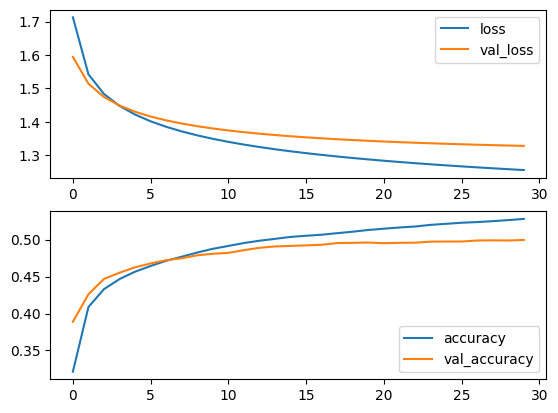

In [61]:
f,axes = plt.subplots(2)
history_frame = pd.DataFrame(history2)
history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1]);

# Evaluating the model

In [62]:
train_loss, train_accuracy = model.evaluate(ds_train)
val_loss, tval_accuracy = model.evaluate(ds_val)
test_loss, test_accuracy = model.evaluate(ds_test)

2023-02-24 19:58:26.665105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 14s 61ms/step - loss: 1.3233 - accuracy: 0.4972


In [63]:
y_train_predictions = np.argmax(model.predict(ds_train),axis=1)
y_val_predictions = np.argmax(model.predict(ds_val),axis=1)
y_test_predictions = np.argmax(model.predict(ds_test),axis=1)

2023-02-24 19:59:35.134110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 13s 57ms/step


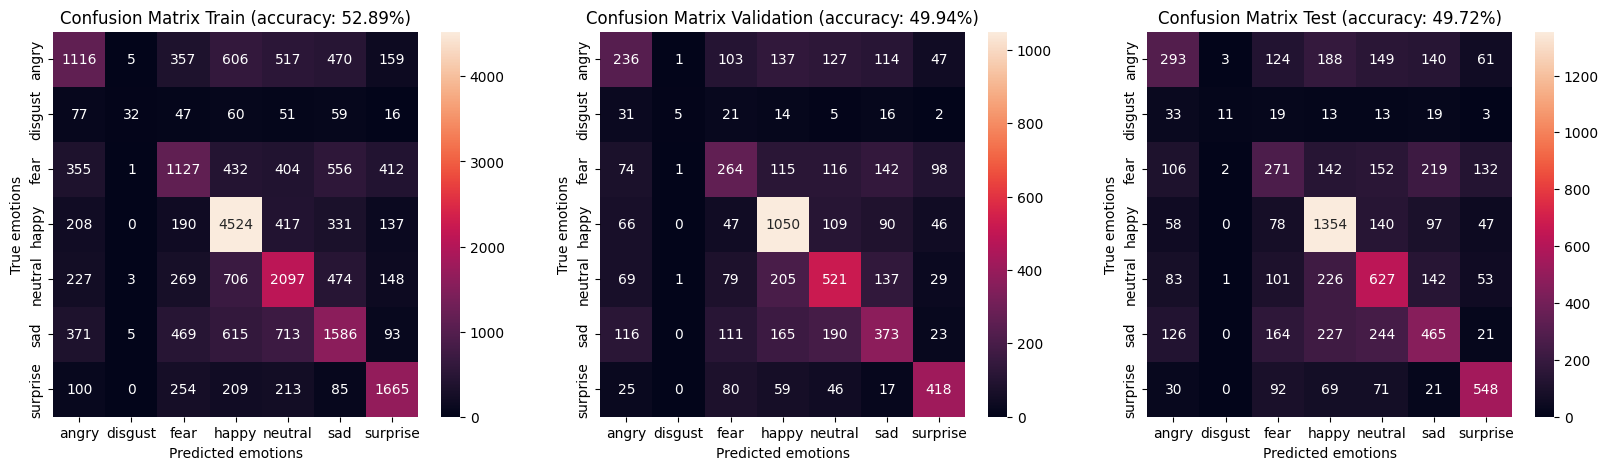

In [64]:
f, axes= plt.subplots(1,3,figsize=(20,5))
accuracies = []
accuracies.append(round(100*accuracy_score(y_train, y_train_predictions),2))
mat = confusion_matrix(y_train, y_train_predictions)
sns.heatmap(mat, annot=True, fmt='g', ax=axes[0]);

accuracies.append(round(100*accuracy_score(y_val, y_val_predictions),2))
mat = confusion_matrix(y_val, y_val_predictions)
sns.heatmap(mat, annot=True, fmt='g', ax=axes[1]);

accuracies.append(round(100*accuracy_score(y_test, y_test_predictions),2))
mat = confusion_matrix(y_test,y_test_predictions)
sns.heatmap(mat, annot=True, fmt='g', ax=axes[2]);

for i in range(3):
    axes[i].set_xlabel('Predicted emotions');axes[i].set_ylabel('True emotions'); 
    axes[i].set_title('Confusion Matrix '+titles[i]+ " (accuracy: {}%)".format(accuracies[i])); 
    axes[i].xaxis.set_ticklabels(class_names); axes[i].yaxis.set_ticklabels(class_names);

### There are very few "disgust" examples so they're the most difficult ones to predict, on the other hand "happy" is widely represented so it predicts them very well

# Data augmentation

In [67]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=(-0.2,0,2))
    ])
    ds_train_augmented = ds_train.map(
        lambda x, y: (data_augmentation(x), y)
    )
    ds_val_augmented = ds_val.map(
        lambda x, y: (data_augmentation(x), y)
    )

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
                trainable=False),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    ds_train_augmented,
    validation_data=ds_val_augmented,
    epochs=30,
)
model.save('my_model_data_augmentation1.h5')
with open('history_data_augmentation1.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_23 (KerasLayer)  (None, 1024)             1529968   
                                                                 
 dense_23 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 1,537,143
Trainable params: 7,175
Non-trainable params: 1,529,968
_________________________________________________________________
Epoch 1/30


2023-02-24 20:22:55.124807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - ETA: 0s - loss: 1.7896 - accuracy: 0.2739

2023-02-24 20:24:16.455762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - 107s 144ms/step - loss: 1.7896 - accuracy: 0.2739 - val_loss: 1.7136 - val_accuracy: 0.3181
Epoch 2/30
718/718 [==============================] - 96s 134ms/step - loss: 1.6782 - accuracy: 0.3360 - val_loss: 1.6430 - val_accuracy: 0.3600
Epoch 3/30
718/718 [==============================] - 96s 134ms/step - loss: 1.6310 - accuracy: 0.3635 - val_loss: 1.6134 - val_accuracy: 0.3708
Epoch 4/30
718/718 [==============================] - 96s 134ms/step - loss: 1.6059 - accuracy: 0.3756 - val_loss: 1.6020 - val_accuracy: 0.3717
Epoch 5/30
718/718 [==============================] - 96s 134ms/step - loss: 1.5850 - accuracy: 0.3834 - val_loss: 1.5797 - val_accuracy: 0.3867
Epoch 6/30
718/718 [==============================] - 96s 134ms/step - loss: 1.5726 - accuracy: 0.3904 - val_loss: 1.5620 - val_accuracy: 0.3851
Epoch 7/30
718/718 [==============================] - 95s 133ms/step - loss: 1.5569 - accuracy: 0.3982 - val_loss: 1.5570 - val_accuracy: 0.

In [68]:
model = load_model('my_model_data_augmentation1.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('history_data_augmentation1.pkl', 'rb') as f:
    history2 = pickle.load(f)

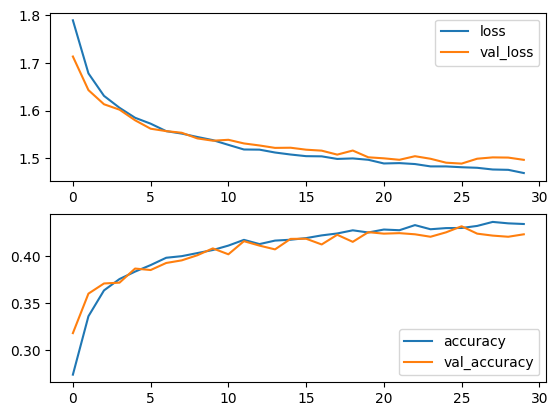

In [69]:
f,axes = plt.subplots(2)
history_frame = pd.DataFrame(history2)
history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1]);

### Its remarkable the overfitting improvement, the distance between the validation and training loss has decreased a lot so let's try increasing the pochs

In [70]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
                trainable=False),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    ds_train_augmented,
    validation_data=ds_val_augmented,
    epochs=60,
)
model.save('my_model_data_augmentation2.h5')
with open('history_data_augmentation2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_24 (KerasLayer)  (None, 1024)             1529968   
                                                                 
 dense_24 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 1,537,143
Trainable params: 7,175
Non-trainable params: 1,529,968
_________________________________________________________________
Epoch 1/60


2023-02-24 21:11:17.651031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - ETA: 0s - loss: 1.7931 - accuracy: 0.2645

2023-02-24 21:12:40.621771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - 109s 145ms/step - loss: 1.7931 - accuracy: 0.2645 - val_loss: 1.7126 - val_accuracy: 0.3109
Epoch 2/60
718/718 [==============================] - 97s 135ms/step - loss: 1.6839 - accuracy: 0.3268 - val_loss: 1.6575 - val_accuracy: 0.3505
Epoch 3/60
718/718 [==============================] - 97s 135ms/step - loss: 1.6373 - accuracy: 0.3552 - val_loss: 1.6227 - val_accuracy: 0.3640
Epoch 4/60
718/718 [==============================] - 97s 135ms/step - loss: 1.6105 - accuracy: 0.3705 - val_loss: 1.6041 - val_accuracy: 0.3714
Epoch 5/60
718/718 [==============================] - 97s 135ms/step - loss: 1.5883 - accuracy: 0.3832 - val_loss: 1.5865 - val_accuracy: 0.3818
Epoch 6/60
718/718 [==============================] - 97s 135ms/step - loss: 1.5758 - accuracy: 0.3852 - val_loss: 1.5735 - val_accuracy: 0.3837
Epoch 7/60
718/718 [==============================] - 96s 134ms/step - loss: 1.5666 - accuracy: 0.3898 - val_loss: 1.5653 - val_accuracy: 0.

In [71]:
model = load_model('my_model_data_augmentation2.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('history_data_augmentation2.pkl', 'rb') as f:
    history2 = pickle.load(f)

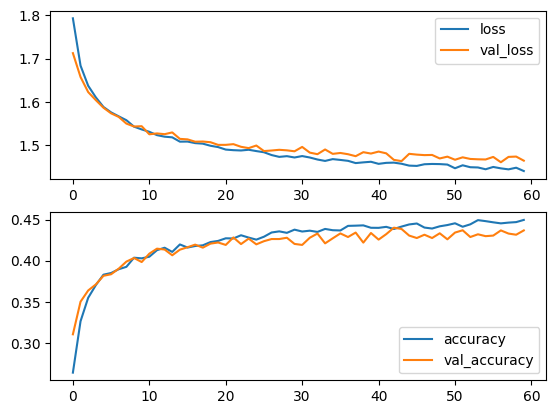

In [72]:
f,axes = plt.subplots(2)
history_frame = pd.DataFrame(history2)
history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1]);